In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [ ]:
# Set dataset path
DATASET_PATH = "/content/drive/MyDrive/DIP Project/Crack Forest"

# Image & Mask folders
IMAGE_PATH = os.path.join(DATASET_PATH, "Images")
MASK_PATH = os.path.join(DATASET_PATH, "Masks")

# List all image and mask files
image_files = sorted(os.listdir(IMAGE_PATH))
mask_files = sorted(os.listdir(MASK_PATH))

# Check if images and masks are correctly paired
print(f"Total Images: {len(image_files)}, Total Masks: {len(mask_files)}")
assert len(image_files) == len(mask_files), "Mismatch in image and mask count!"

Total Images: 118, Total Masks: 118


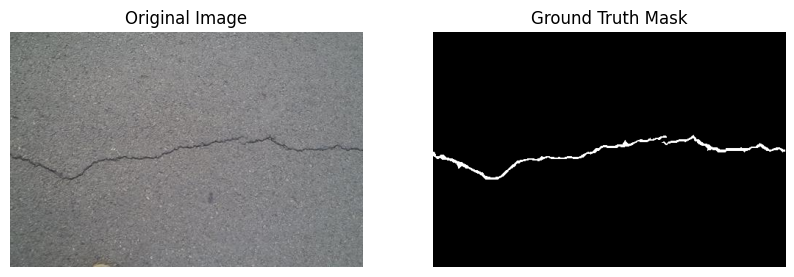

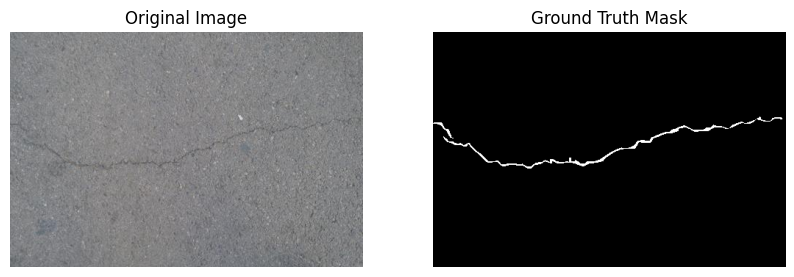

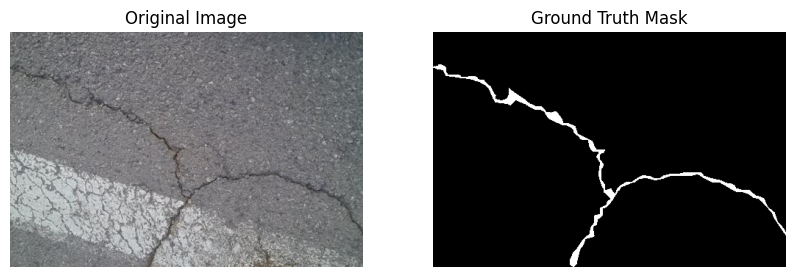

In [ ]:
# Function to display image and mask side by side
def display_sample(index):
    img = load_img(os.path.join(IMAGE_PATH, image_files[index]))
    mask = load_img(os.path.join(MASK_PATH, mask_files[index]), color_mode="grayscale")

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Ground Truth Mask")
    ax[1].axis("off")

    plt.show()

# Display 3 random samples
for i in [0, 10, 20]:  # You can change these indices
    display_sample(i)


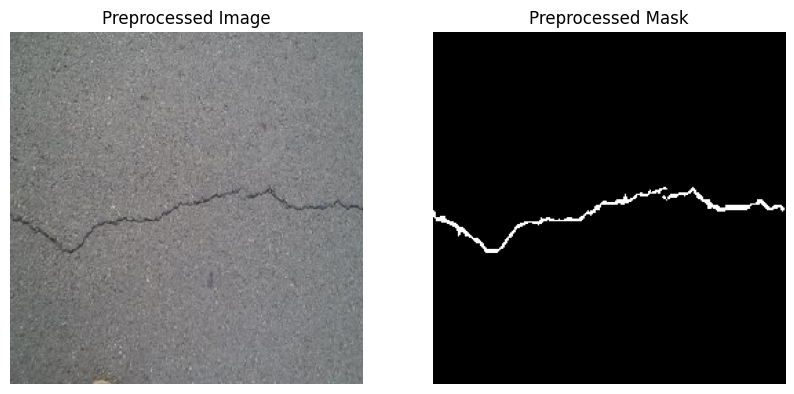

In [ ]:
IMG_HEIGHT, IMG_WIDTH = 256, 256  # Resizing dimensions

def preprocess_image(img_path, mask_path):
    """Load, resize, and normalize an image-mask pair"""
    # Load image & mask
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")

    # Convert to numpy arrays
    img = img_to_array(img) / 255.0  # Normalize image (0 to 1)
    mask = img_to_array(mask) / 255.0  # Normalize mask

    # Convert mask to binary (ensure values are 0 or 1)
    mask = np.where(mask > 0.5, 1, 0).astype(np.uint8)

    return img, mask

# Test the function on a sample
sample_img, sample_mask = preprocess_image(
    os.path.join(IMAGE_PATH, image_files[0]),
    os.path.join(MASK_PATH, mask_files[0])
)

# Display the preprocessed sample
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_img)
ax[0].set_title("Preprocessed Image")
ax[0].axis("off")

ax[1].imshow(sample_mask.squeeze(), cmap="gray")
ax[1].set_title("Preprocessed Mask")
ax[1].axis("off")

plt.show()


In [ ]:
# Lists to store processed images and masks
images, masks = [], []

# Loop through all images and preprocess them
for img_name, mask_name in zip(image_files, mask_files):
    img_path = os.path.join(IMAGE_PATH, img_name)
    mask_path = os.path.join(MASK_PATH, mask_name)

    img, mask = preprocess_image(img_path, mask_path)

    images.append(img)
    masks.append(mask)

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.uint8)  # Masks are binary (0 or 1)

print(f"Dataset Shape - Images: {images.shape}, Masks: {masks.shape}")

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print dataset split sizes
print(f"Training Set: {len(X_train)} samples")
print(f"Validation Set: {len(X_val)} samples")
print(f"Test Set: {len(X_test)} samples")


Dataset Shape - Images: (118, 256, 256, 3), Masks: (118, 256, 256, 1)
Training Set: 94 samples
Validation Set: 12 samples
Test Set: 12 samples


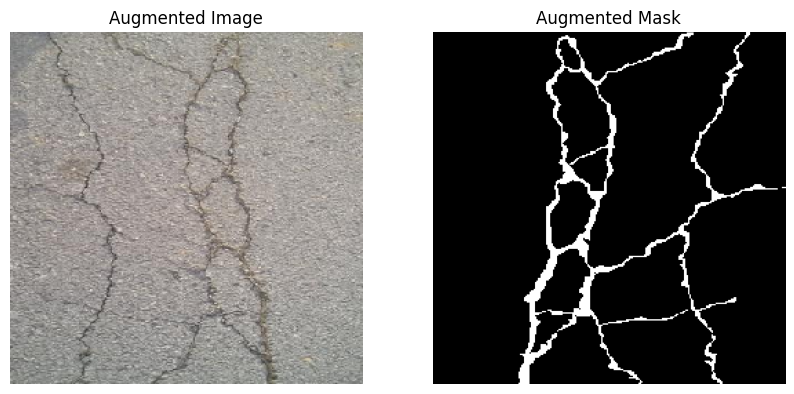

In [ ]:
import tensorflow as tf

# Define augmentation function
def augment(image, mask):
    """Applies random transformations to an image-mask pair"""

    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    mask = tf.image.random_flip_left_right(mask)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)
    mask = tf.image.random_flip_up_down(mask)

    # Random rotation (0°, 90°, 180°, 270°)
    angles = [0, 90, 180, 270]
    angle = tf.random.shuffle(angles)[0]
    image = tf.image.rot90(image, k=angle // 90)
    mask = tf.image.rot90(mask, k=angle // 90)

    # Random brightness adjustment
    image = tf.image.random_brightness(image, 0.2)

    # Random contrast adjustment
    image = tf.image.random_contrast(image, 0.8, 1.2)

    return image, mask

# Convert NumPy datasets to TensorFlow datasets
BATCH_SIZE = 16

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply augmentation only to training data & batch the datasets
train_dataset = (train_dataset
                 .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
                 .shuffle(1000)
                 .batch(BATCH_SIZE)
                 .prefetch(tf.data.AUTOTUNE))

val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Check an augmented sample
sample_img, sample_mask = next(iter(train_dataset))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_img[0])  # First image in batch
ax[0].set_title("Augmented Image")
ax[0].axis("off")

ax[1].imshow(sample_mask[0].numpy().squeeze(), cmap="gray")
ax[1].set_title("Augmented Mask")
ax[1].axis("off")

plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout

def unet_model(input_size=(256, 256, 3)):
    """Builds the U-Net model for crack detection"""

    inputs = Input(input_size)

    # Encoder (Downsampling)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder (Upsampling)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])  # Skip Connection
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])  # Skip Connection
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])  # Skip Connection
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])  # Skip Connection
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Build Model
    model = tf.keras.Model(inputs, outputs)
    return model

# Create U-Net model
unet = unet_model()
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 16, 16, 1024)   │              0 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├──────────────────────

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

# Dice Coefficient Function
def dice_coef(y_true, y_pred, smooth=1):
    """Computes Dice Coefficient"""
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))  # Convert to float32
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))  # Convert to float32
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss Function (1 - Dice Coefficient)
def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Compile the model
unet.compile(optimizer=Adam(learning_rate=1e-4),
             loss=dice_loss,
             metrics=['accuracy', dice_coef])

print("✅ Model compiled successfully!")


✅ Model compiled successfully!


In [ ]:
# Training parameters
EPOCHS = 100  # You can increase this for better results

# Train the model
history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=8
)


Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9752 - dice_coef: 0.1662 - loss: 0.8334 - val_accuracy: 0.9830 - val_dice_coef: 0.5736 - val_loss: 0.4264
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 801ms/step - accuracy: 0.9631 - dice_coef: 0.1603 - loss: 0.8399 - val_accuracy: 0.9878 - val_dice_coef: 0.6312 - val_loss: 0.3688
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 799ms/step - accuracy: 0.9710 - dice_coef: 0.2012 - loss: 0.7990 - val_accuracy: 0.9901 - val_dice_coef: 0.6307 - val_loss: 0.3693
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 809ms/step - accuracy: 0.9737 - dice_coef: 0.1391 - loss: 0.8608 - val_accuracy: 0.9878 - val_dice_coef: 0.6294 - val_loss: 0.3706
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 817ms/step - accuracy: 0.9674 - dice_coef: 0.1987 - loss: 0.8016 - val_accuracy: 0.9872 - val_dice_coef: 0.6218 - val_loss: 0.3782
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 818ms/step - accuracy: 0.9727 - dice_coef: 0.2673 - loss: 0.7319 - val_accuracy: 0.9894 - val_dice_coef: 0.

In [ ]:
# Evaluate on test dataset
test_loss, test_acc, test_dice = unet.evaluate(test_dataset)
print(f"✅ Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Dice Coefficient: {test_dice:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9841 - dice_coef: 0.6766 - loss: 0.3234
✅ Test Loss: 0.3234
✅ Test Accuracy: 0.9841
✅ Test Dice Coefficient: 0.6766


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


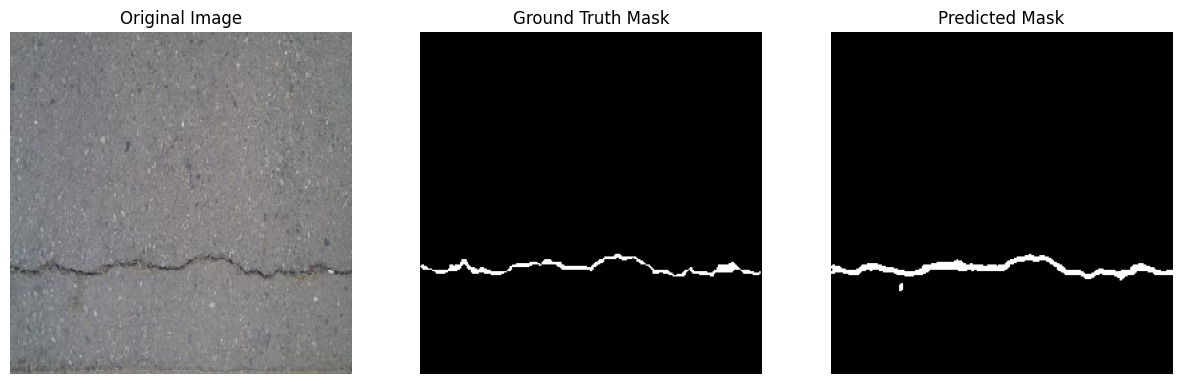

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Get a random test sample
test_sample = next(iter(test_dataset))  # Get one batch
test_image, test_mask = test_sample[0][10], test_sample[1][10]  # First image in batch

# Make a prediction
predicted_mask = unet.predict(np.expand_dims(test_image, axis=0))[0]

# Convert predicted mask to binary (threshold at 0.5)
binary_mask = (predicted_mask > 0.5).astype(np.uint8)

# Plot original image, ground truth mask, and predicted mask
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(test_image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(test_mask.numpy().squeeze(), cmap="gray")
ax[1].set_title("Ground Truth Mask")
ax[1].axis("off")

ax[2].imshow(binary_mask.squeeze(), cmap="gray")
ax[2].set_title("Predicted Mask")
ax[2].axis("off")

plt.show()


In [ ]:
unet.save("crack_detection_unet.h5")
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained U-Net model
unet = load_model("crack_detection_unet.h5", custom_objects={"dice_coef": dice_coef, "dice_loss": dice_loss})
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a new image
# image_path = "/content/drive/MyDrive/DIP Project/Crack Forest/Images/023.jpg"
image_path = "/content/drive/MyDrive/DIP Project/Test Images/Test_12.jpeg"
image = cv2.imread(image_path)  # Read image
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
image = cv2.resize(image, (256, 256))  # Resize to match model input size
image = image / 255.0  # Normalize (0 to 1)


In [ ]:
# Expand dimensions to match model input shape (batch_size, height, width, channels)
input_image = np.expand_dims(image, axis=0)

# Predict the crack mask
predicted_mask = unet.predict(input_image)[0]

# Convert to binary mask (threshold at 0.5)
binary_mask = (predicted_mask > 0.5).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


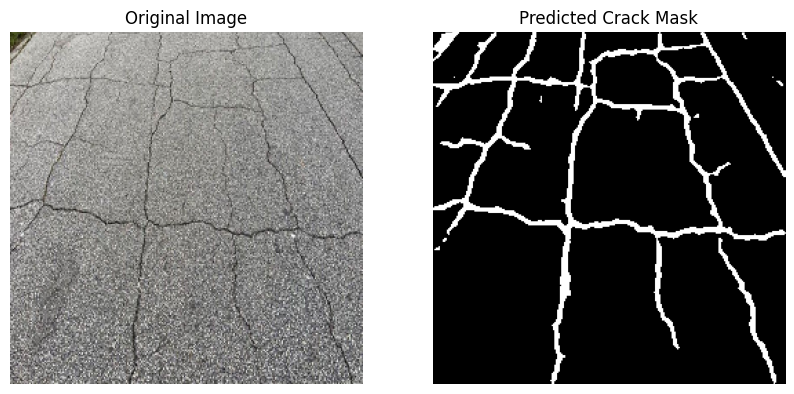

In [ ]:
# Plot original image and predicted mask
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(image)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(binary_mask.squeeze(), cmap="gray")
ax[1].set_title("Predicted Crack Mask")
ax[1].axis("off")

plt.show()
